# Model for hand-written digits classification

## Contents
* [Task description](#Task-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Selection of hyperparameters](#Selection-of-hyperparameters)
* [Training](#Training)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Operating time](#Operating-time)
* [Criticism](#Criticism)
* [Summary](#Summary)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further-development)

## Task description
Image classification of hand-written digits


## Dataset

For training and model performance assessment we use the MNIST dataset.

Dataset consists of two parts: train (60k items) and test (10k items).
Each one consists of:
* an array of images of size 28х28 pixels in greyscale
* an array of labels corresponding to a digit on each image.

Collection of dataset and labeling process are described at [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/).

Dataset loading

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join("..", ".."))
from batchflow import best_practice, B, F, V, C, R, Pipeline
from batchflow.opensets import MNIST
from batchflow.models.tf import TFModel
from batchflow.research import Results

from src import (show_samples, class_histogram, show_loss, show_histogram,
                 get_confusion_matrix, class_precision)

mnist = MNIST()

Extracting /tmp/train-images-idx3-ubyte.gzExtracting /tmp/train-labels-idx1-ubyte.gz

Extracting /tmp/t10k-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz


Distribution of a number of examples for each class in train and test set.
As we can see classes are quietly balanced.

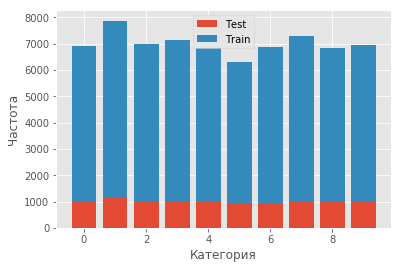

In [2]:
train = mnist.train.next_batch(len(mnist.train))
test = mnist.test.next_batch(len(mnist.test))

class_histogram(train, test)

Examples of dataset items.

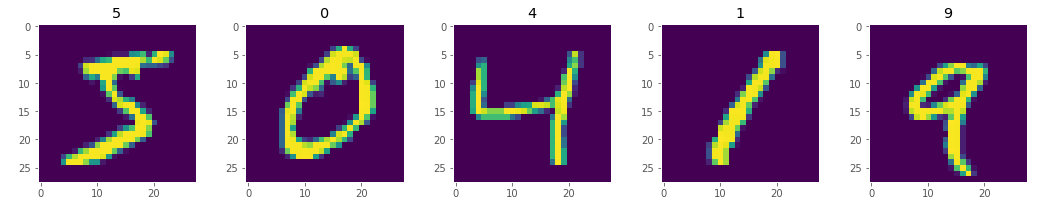

In [3]:
size = 5

show_samples(train.to_array().images[:size, :, :, 0], labels=train.labels[:size])

Data reliability is proved by multiple usages in research e.g. 
* https://arxiv.org/pdf/1704.07709
* https://arxiv.org/abs/1302.4389
* https://arxiv.org/abs/1312.4400.

## Model architecture

We use a convolutional neural network consisting of 3 identical blocks.
The network architecture can be described by layout `cpna cpna cpna Pf`, where letters correspond to the following layers:
* `с` - 2d convolution
* `p` - max pooling
* `n` - batch normalisation
* `a` - activation
* `P` - global average pooling
* `f` - dense

Convolutional layer parameters `c`:
* ```filters```= 64 * 2**i, where i - block number, i=0, 1, 2.
* ```kernel_size``` = 3
* ```strides``` = 2
* ```padding``` = 'same'
* ```data_format``` = 'channels_last'
* ```activation``` = `None`

Pooling layer parameters `p`:
* ```pool_size``` = 2
* ```pool_strides``` = 1.

Activation layer parameters `a`:
* `activation` = `tf.nn.relu`

Dense layer parameters `dense`:
* `filters` = 10
* `activation` = `None`

Model description config:

In [4]:
NUM_CLASSES = 10

model_config = {
    'inputs': dict(images=dict(shape=B('image_shape')),
                   labels=dict(classes=NUM_CLASSES, transform='ohe', name='targets')),
    'body': dict(layout='cpna cpna cpna', filters=[64, 128, 256],
                 strides=2, pool_strides=1, kernel_size=3),
    'head': dict(layout='Pf', units=NUM_CLASSES),
    'initial_block/inputs': 'images',
    'loss': 'crossentropy',
    'optimizer': ('Momentum', {'use_nesterov': True, 'learning_rate': 0.01, 'momentum': 0.5}),
    'output': ['proba']}

## Selection of hyperparameters

The choice of this architecture (number of blocks and number of filters in convolutional layers) is motivated by the [research](https://github.com/analysiscenter/standards/blob/model/model_examples/classification_model/parameters_estimation.ipynb).

Other parameters such as an activation function and single block layout are chosen due to the common standards. 

## Training

We train our model using stochastic gradient descent. On each iteration we
* load mini-batch data
* update the weights 

Algorith of weights update (optimizer) is the Nesterov momentum with hyperparameters:
* ```learning_rate``` = 0.01
* ```mu``` = 0.5

The choice of optimizer hyperparameters is motivated by the [research](../../research_examples/model_training/optimizer_search.ipynb), as for they show the best convergence.

Loss - cross-entropy.

Dataset bypass:
* ```batch_size``` = 64
* ```n_epochs``` = 10.

Training pipeline:

In [5]:
train_template = (Pipeline()
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_model('dynamic', TFModel, 'mnist_model', config=model_config)
                  .to_array()
                  .train_model('mnist_model', fetches='loss',
                               feed_dict={'images': B('images'),
                                          'labels': B('labels')}, 
                               save_to=V('loss_history'), mode='a'))

Execute training

In [6]:
train_pipeline = ((train_template << mnist.train)
                  .run(64, shuffle=True, n_epochs=1, drop_last=True, bar=True))

100%|██████████| 937/937 [02:31<00:00,  6.48it/s]


The loss function vs number of iterations:

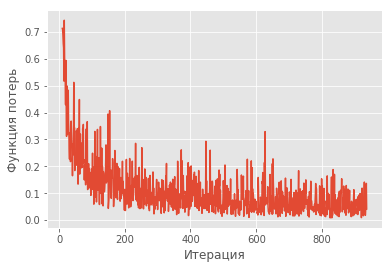

In [7]:
show_loss(train_pipeline.get_variable('loss_history'), skip=10)

## Inference

Prediction pipeline:

In [8]:
predict_template = (Pipeline()
                    .import_model('mnist_model', train_pipeline)
                    .init_variable("predictions", init_on_each_run=list)
                    .to_array()
                    .predict_model('mnist_model', fetches='proba',
                                   feed_dict={'images': B('images')},
                                   save_to=V('predictions'), mode="e"))

Execute prediction pipeline

In [9]:
predict_pipeline = ((predict_template << mnist.test)
                    .run(64, shuffle=False, n_epochs=1, drop_last=False, bar=True))

 99%|█████████▉| 156/157 [00:06<00:00, 23.95it/s]


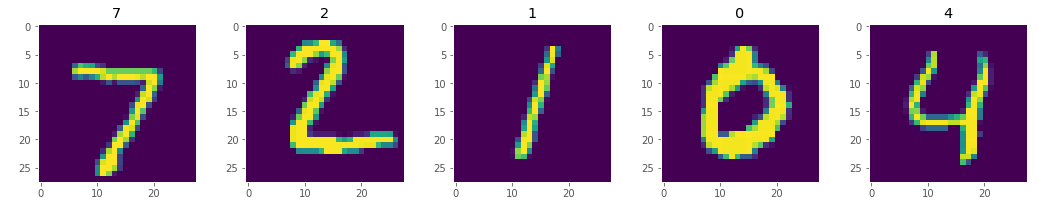

In [10]:
size = 5
y_pred = predict_pipeline.get_variable('predictions')
show_samples(test.to_array().images[:size, :, :, 0], labels=np.argmax(y_pred[:size], axis=1))

## Model evaluation

Quality metric, in this case, is ```accuracy``` on the test set.

Metric evaluation pipeline:

In [11]:
test_template = (Pipeline()
                 .import_model('mnist_model', train_pipeline)
                 .init_variable('predictions', init_on_each_run=list)
                 .init_variable('metrics', init_on_each_run=None)
                 .to_array()
                 .predict_model('mnist_model', fetches='proba', 
                                feed_dict={'images': B('images')},
                                save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                 fmt='proba', axis=-1, save_to=V('metrics'), mode='u'))

In [12]:
test_pipeline = ((test_template << mnist.test)
                 .run(64, shuffle=False, n_epochs=1, drop_last=True, bar=True))

100%|██████████| 156/156 [00:07<00:00, 21.51it/s]


In [13]:
metrics = test_pipeline.get_variable('metrics')
print("Accuracy: %.3f" % metrics.evaluate('accuracy'))

Accuracy: 0.985


For model performance assessment an [experiment](./model_estimation.ipynb) was conducted on 20 model training launches from  scratch.

Research results loading and a distribution for `accuracy`:

In [14]:
df = Results(path='model_estimation_research').load()
values = df[df['name'] == 'test']['metrics'].apply(lambda x: x.evaluate('accuracy')).values

`Accuracy` histogram

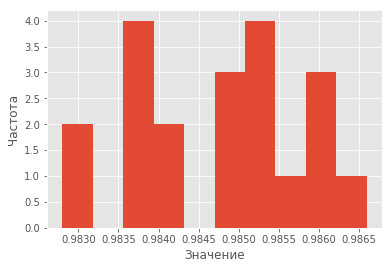

Среднее значение (медиана): 0.985


In [15]:
show_histogram(values)
print('Среднее значение (медиана): %.3f' % np.median(values))

Average value (median): 0.0985

```confusion_matrix``` on 10 classes (rows and columns are numbered from 0 до 9 corresponding to the numbers on
the images):

In [16]:
cfm = get_confusion_matrix(metrics)
print(cfm)

[[ 974    0    3    1    1    1    7    0    6    1]
 [   0 1127    2    0    0    0    4    2    0    0]
 [   2    1 1016    3    1    0    0    4    0    0]
 [   0    2    2  991    0    7    0    2    3    1]
 [   0    0    1    1  962    1    2    0    2    1]
 [   1    1    0    5    0  878    5    0    2    4]
 [   0    0    0    0    0    1  934    0    0    1]
 [   2    1    3    2    0    0    0 1011    0    4]
 [   0    1    3    3    3    1    4    0  951    4]
 [   0    0    0    2   13    1    0    8    9  992]]


 `Precision` Histogram for each class:

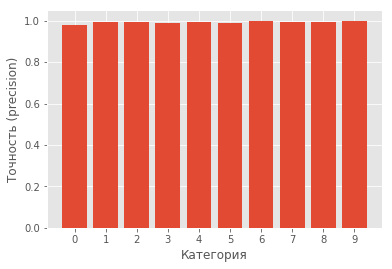

In [17]:
class_precision(cfm)

## Operating time

Device: CPU i7.

One train step on batch size 64 takes 200 ms. Training time is 32 s.

One image inference takes 3 ms, for batch size 64 - 44 ms.

## Criticism

To identify weak spots of the model we performed model prediction on the shifted images.
To do so we added an image shift step to the prediction pipeline. An image is shifted on a random number of pixels from the uniform distribution in [-5, 5]

In [18]:
template_criticism_pipeline = (
  Pipeline()
    .import_model("mnist_model", train_pipeline)
    .init_variable("predictions")
    .init_variable("metrics", init_on_each_run=None)
    .shift((R("randint", -5, 5), R("randint", -5, 5)))
    .to_array()
    .predict_model("mnist_model", fetches="predictions", save_to=V("predictions"),
                   feed_dict={"images": B("images")})
    .gather_metrics("class", targets=B("labels"), predictions=V("predictions"),
                    fmt="logits", axis=-1, save_to=V("metrics"), mode="u")
    .run(batch_size=64, n_epochs=1, drop_last=False, bar=True, lazy=True)
)

Run criticism pipeline

In [19]:
criticism_pipeline = (mnist.test >> template_criticism_pipeline).run()

 99%|█████████▉| 156/157 [00:07<00:00, 20.65it/s]


Compute `accuracy`

In [20]:
print("Accuracy: %.3f" % criticism_pipeline.get_variable("metrics").evaluate("accuracy"))

Accuracy: 0.810


Accuracy decreased by 20%, which means the model is sensitive to a shift.

## Summary

The model classifies images of size 28х28 with digits in greyscale. The average (median) model accuracy is 98.5%.


## Proposals for the improvement and further development

For robust classification improvement (relative to the shift of an image from the central position) we suggest to include augmentation to the training pipeline.